In [1]:
from importlib.metadata import version

pkgs = ['numpy', 'matplotlib', 'tiktoken', 'torch']
for p in pkgs:
    print(f"{p} version: {version(p)}")

!which python; python --version

numpy version: 2.1.2
matplotlib version: 3.9.2
tiktoken version: 0.9.0
torch version: 2.4.1
/mnt/lustre/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15


In [2]:
import math
from dataclasses import dataclass
import torch
import tiktoken
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import os, time, inspect
import urllib.request

file_path = 'input.txt'
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text = response.read().decode('utf-8')
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(text)
else:
    with open(file_path, "r", encoding='utf-8') as file:
        text = file.read()

text = text[:1000] # first 1,000 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
@dataclass
class GPTConfig:
    # config for gpt2 124M model
    block_size: int = 1024
    vocab_size: int = 50257 # 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768


# TODO
@dataclass
class TokenformerConfig:
    pass

In [4]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # note that these matrices also have a bias!
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # Wq, Wk, Wv matrices
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)     # Wo: final projection
        self.c_proj.NANOGPT_SCALE_INIT = 1.0  # a flag to identify this particular module
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # note: name is misleading, it is actually the causal mask, not bias!
        # this is the autoregressive mask
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x) # B, T, 3*d
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # these 4 lines can be replaced by flash attention
        # flash attention never materializes the TxT att matrix in GPU memory
        # relies on online softmax calculation
        """
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v
        """
        # replace by this line
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        # gaussian error linear unit, approximation is a historical quirk
        # gelu always contributes a local gradient in the tail end of the flat region
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x



class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # prefer clean residual stream from outputs to all the way back to inputs
        # no normalization in the residual streams
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict( # the main container
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # layers will be indexed by integers (0, 1, ...) instead of names (like wpe, wte)
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd), # final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight tying scheme
        # wte weight redirected to the lm_head weight
        # wte weight original gets orphaned and hopefully cleaned up
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                # 2 times num layers as each layer adds 2 times to the residual path
                # once by attn layer and another time by the MLP layer
                std *= (2 * self.config.n_layer) ** (-0.5)
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # zero init bias is not pytorch default
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape [B, T]
        B, T = idx.size()
        assert T <= self.config.block_size
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) #    [T, n_embd]
        tok_emb = self.transformer.wte(idx) # [B, T, n_embd]
        x = tok_emb + pos_emb               # broadcasting hidden

        for block in self.transformer.h:
            x = block(x)
        
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.flatten(0, 1), targets.flatten())

        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t()) # inplace copying of a tensor
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k]) # inplace copying of a tensor

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device):
        # just pick out params that require grad
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups -- all 2d params will be weight decayed, biases and layernorms no decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and "cuda" in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer
        

In [5]:
# device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
# elif hasattr(torch.backends, "mps") and torch.mps.is_available():
#     device = "mps"
# print(f"using device: {device}")
# # device = "cpu" # OVERRIDE

In [6]:
# num_return_sequences = 5
# max_length = 30

# # model = GPT.from_pretrained('gpt2')
# model = GPT(GPTConfig()) # randomly initialized model
# model.eval()
# model.to(device);

# enc = tiktoken.get_encoding('gpt2')
# tokens = enc.encode("Hello, I'm a language model,")
# tokens = torch.tensor(tokens, dtype=torch.long)
# tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # repeat same row 5 times
# x = tokens.to(device)

In [7]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# while x.size(1) < max_length:
#     with torch.no_grad():
#         logits, _ = model(x) # [B, T, V]
#         logits = logits[:, -1, :]
#         probs = F.softmax(logits, dim=-1)
#         topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
#         # select a token from top-50 tokens according to probabilities
#         ix = torch.multinomial(topk_probs, 1)
#         xcol = torch.gather(topk_indices, -1, ix)
#         x = torch.cat((x, xcol), dim=1)

# for i in range(num_return_sequences):
#     tokens = x[i, :].tolist()
#     decoded = enc.decode(tokens)
#     print(f"> {decoded}")

In [8]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B, self.T = B, T

        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B*T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        self.current_position += B*T
        if self.current_position + B*T + 1 > len(self.tokens):
            self.current_position = 0
        return x, y

In [9]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.mps.is_available():
    device = "mps"
print(f"using device: {device}")
# device = "cpu" # OVERRIDE


torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

using device: cuda


In [10]:
total_batch_size = 524_288 # 2**19, closest power of 2 to ~0.5M
B = 16   # micro batch size: how many rows we are processing in a single forward-backward
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "total batch size in # tokens is divisible by B*T"
grad_accum_steps = total_batch_size // (B * T)
print(f"total desired batch size: {total_batch_size} tokens")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# initialize the dataloader
train_loader = DataLoaderLite(B, T)

total desired batch size: 524288 tokens
=> calculated gradient accumulation steps: 32
loaded 338025 tokens
1 epoch = 20 batches


In [11]:
# enable tf32, now matmuls will use tf32 (tensor cores from A100)
torch.set_float32_matmul_precision('high') # default is highest

In [12]:
max_lr = 6e-4 # prev constant lr that we were using
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps=50

In [13]:
def get_lr(it):
    # linear warmup
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # if it > lr decay iters, return min_lr
    if it > max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # starts at 1, goes to 0
    return min_lr + coeff * (max_lr - min_lr)

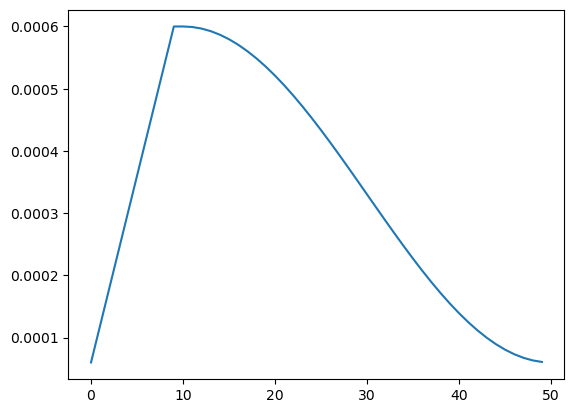

In [14]:
steps = np.arange(max_steps)
lrs = np.array([get_lr(it) for it in steps])

plt.plot(steps, lrs)

In [15]:
# len(optimizer.param_groups)

In [16]:
# model = GPT(GPTConfig())
model = GPT(GPTConfig(vocab_size=50304)) # 6th optimization
model.to(device)
model = torch.compile(model) #4th optimization

# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device) # fused update

max_steps = 50
for step in range(max_steps):
    # start timer
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0

    # gradient-accumulation
    for micro_step in range(grad_accum_steps):
        # data loading
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
    
        # forward-backward and step
        # amp for 3rd optimization, just surround forward pass and loss calculation, only possible in A100
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward() # deposits gradients, i.e., += on nodes

    # clip gradient norms to 1.0, returns total norm of the gradient vector
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # determine lr for this step
    lr = get_lr(step)
    # pytorch syntax to set the learning rate for the parameters
    for param_group in optimizer.param_groups:
        # param_group is a dict
        param_group['lr'] = lr
    optimizer.step()

    # wait for gpu to finish the compute and measure time
    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0)*1000 # time difference for one-batch or step in miliseconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tps = tokens_processed / (t1 - t0)
    
    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tps:.2f}")


print(f"logits.shape: {logits.shape}, logits dtype: {logits.dtype}, loss.dtype: {loss.dtype}")

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Step    0 | loss: 10.938566 | lr: 6.0000e-05 | norm: 27.0126 | dt: 48163.27ms | tok/sec: 10885.64
Step    1 | loss: 9.649344 | lr: 1.2000e-04 | norm: 9.5177 | dt: 3460.72ms | tok/sec: 151496.72
Step    2 | loss: 9.225602 | lr: 1.8000e-04 | norm: 5.7290 | dt: 3461.05ms | tok/sec: 151482.52
Step    3 | loss: 9.813100 | lr: 2.4000e-04 | norm: 8.2066 | dt: 3462.22ms | tok/sec: 151431.37
Step    4 | loss: 9.191634 | lr: 3.0000e-04 | norm: 4.2995 | dt: 3462.32ms | tok/sec: 151426.76
Step    5 | loss: 8.678035 | lr: 3.6000e-04 | norm: 3.6285 | dt: 3463.89ms | tok/sec: 151358.17
Step    6 | loss: 8.294984 | lr: 4.2000e-04 | norm: 1.9536 | dt: 3466.73ms | tok/sec: 151234.21
Step    7 | loss: 8.068030 | lr: 4.8000e-04 | norm: 2.8520 | dt: 3465.58ms | tok/sec: 151284.39
Step    8 | loss: 7.714195 | lr: 5.4000e-04 | norm: 1.9110 | dt: 3469.67ms | tok

### 1. baseline (all computations in float32):
```
Step 0 loss: 10.988560676574707, dt: 1302.39ms, tok/sec: 12579.96
...
Step 49 loss: 6.0608367919921875, dt: 1131.17ms, tok/sec: 14484.17
```
### 2. tensorcore (tf32) matmul, but all computations still in float32:
- we added `torch.set_float32_matmul_precision('high')`
- okay so throughput increased from $14,000$ to $40,000$
```
Step 0 loss: 10.935468673706055, dt: 1369.09ms, tok/sec: 11967.11
...
Step 49 loss: 6.053790092468262, dt: 403.40ms, tok/sec: 40614.37
torch.Size([16, 1024, 50257]) torch.float32 torch.float32
```
- this change is local to the matmul operation, so we see the dtype of everythig is still `fp32`
### 3. mixed precision: dropping down everythin to bfloat16 (similar to tf32):
- exponent bits for `fp32`, `tf32` and `bf16` are all same (8 bits for exponent)
- their range is same, but now it is reduced precision
- note that we are not doing `fp16` as that reduced exponent bits (not same range)
- what exactly is **mixed** precision? the parameters/weights are still in `fp32`, but the logits are now in `bf16`
- why we are using `bf6` instead of `fp16` in `with torch.autocast(device_type=device, dtype=torch.bfloat16)`? because if we used `fp16` we would need to use gradient scalers
- this is only possible in ampere ie A100s
- similarly fp8 is only possible in H100s
```
Step 0 loss: 10.982086181640625, dt: 1479.24ms, tok/sec: 11075.94
Step 1 loss: 9.621953964233398, dt: 359.68ms, tok/sec: 45551.13
Step 2 loss: 9.218406677246094, dt: 342.26ms, tok/sec: 47870.29
...
Step 49 loss: 5.9743523597717285, dt: 343.68ms, tok/sec: 47672.53
torch.Size([16, 1024, 50257]) torch.bfloat16 tensor(5.9744, device='cuda:0', grad_fn=<NllLossBackward0>) torch.float32
```


### 4. use `model=torch.compile(model)`:
- costs compile time
- reduces back and forth moving between gpu memory
- when you have the entire model computation graph available with you, why do eager execution?
- **massive** throughput gain from $47,000$ to $103,000$
```
Step 0 loss: 10.935879707336426, dt: 119321.65ms, tok/sec: 137.31
Step 1 loss: 9.398224830627441, dt: 153.08ms, tok/sec: 107029.85
Step 2 loss: 8.942508697509766, dt: 155.39ms, tok/sec: 105436.13
...
Step 47 loss: 6.1945366859436035, dt: 158.20ms, tok/sec: 103566.34
Step 48 loss: 6.1350908279418945, dt: 156.87ms, tok/sec: 104445.94
Step 49 loss: 6.056550025939941, dt: 157.70ms, tok/sec: 103893.43
torch.Size([16, 1024, 50257]) torch.bfloat16 tensor(6.0566, device='cuda:0', grad_fn=<CompiledFunctionBackward>) torch.float32
```


### 5. introduce flash attention:
- basically another kernel optimization that `torch.compile` cannot find on its own
- based on online softmax calculation
- 
```
Step 0 loss: 10.9359130859375, dt: 23674.47ms, tok/sec: 692.05
Step 1 loss: 9.398143768310547, dt: 113.62ms, tok/sec: 144203.84
Step 2 loss: 8.942390441894531, dt: 115.83ms, tok/sec: 141449.32
...
Step 47 loss: 6.194267272949219, dt: 117.96ms, tok/sec: 138894.85
Step 48 loss: 6.1363019943237305, dt: 117.95ms, tok/sec: 138904.39
Step 49 loss: 6.058759689331055, dt: 116.97ms, tok/sec: 140074.31
torch.Size([16, 1024, 50257]) torch.bfloat16 tensor(6.0588, device='cuda:0', grad_fn=<CompiledFunctionBackward>) torch.float32
```


### 6. change vocabulary size to nearest power of 2:
- nice numbers are good to have
- adding fake tokens to the vocabulary, these tokens are never used
- predicting probabilities for tokens that were never present in the training set, so the network has to learn to drive the probabilities for those tokens to zero
```
Step 0 loss: 10.924062728881836, dt: 23784.74ms, tok/sec: 688.85
Step 1 loss: 9.522332191467285, dt: 109.65ms, tok/sec: 149423.95
Step 2 loss: 9.18037223815918, dt: 113.67ms, tok/sec: 144132.47
...
Step 47 loss: 6.144783973693848, dt: 113.11ms, tok/sec: 144852.81
Step 48 loss: 6.116957187652588, dt: 113.76ms, tok/sec: 144020.40
Step 49 loss: 5.957751750946045, dt: 113.51ms, tok/sec: 144333.78
torch.Size([16, 1024, 50304]) torch.bfloat16 tensor(5.9578, device='cuda:0', grad_fn=<CompiledFunctionBackward>) torch.float32

```
- so slight increase in timming with this, not much!

### 7. hyperparameters:
- introduce AdamW betas
- gradient norm clipping to 1
- norms should stabilize as happening here
```
Step    0 | loss: 10.947336 | norm: 28.5686 | dt: 19151.34ms | tok/sec: 855.50
Step    1 | loss: 9.388495 | norm: 6.1851 | dt: 153.79ms | tok/sec: 106537.86
Step    2 | loss: 8.949816 | norm: 2.4913 | dt: 145.93ms | tok/sec: 112272.97
...
Step   47 | loss: 6.053903 | norm: 0.9616 | dt: 113.84ms | tok/sec: 143923.88
Step   48 | loss: 5.986834 | norm: 0.8159 | dt: 114.86ms | tok/sec: 142641.07
Step   49 | loss: 5.901224 | norm: 0.7297 | dt: 115.14ms | tok/sec: 142296.38
torch.Size([16, 1024, 50304]) torch.bfloat16 tensor(5.9012, device='cuda:0', grad_fn=<CompiledFunctionBackward>) torch.float32
```

### 8. learning rate scheduler
- warm-up
- cosine decay has been popularized by GPT2 and 3, but other schedulers also exist
- we do actually go to a lower loss value!
```
Step    0 | loss: 10.901613 | lr: 5.9999999999999995e-05 | norm: 26.4353 | dt: 17998.45ms | tok/sec: 910.30
Step    1 | loss: 9.676805 | lr: 0.00011999999999999999 | norm: 9.6122 | dt: 113.05ms | tok/sec: 144923.99
Step    2 | loss: 9.136786 | lr: 0.00017999999999999998 | norm: 3.1799 | dt: 114.70ms | tok/sec: 142848.04
Step    3 | loss: 9.215250 | lr: 0.00023999999999999998 | norm: 6.7971 | dt: 113.99ms | tok/sec: 143733.92
...
Step   47 | loss: 5.876487 | lr: 6.746012149262733e-05 | norm: 0.6398 | dt: 112.87ms | tok/sec: 145163.08
Step   48 | loss: 5.854237 | lr: 6.332414803931283e-05 | norm: 0.8459 | dt: 115.68ms | tok/sec: 141630.65
Step   49 | loss: 5.710653 | lr: 6.083231989205545e-05 | norm: 1.0062 | dt: 114.64ms | tok/sec: 142922.91
torch.Size([16, 1024, 50304]) torch.bfloat16 tensor(5.7107, device='cuda:0', grad_fn=<CompiledFunctionBackward>) torch.float32
```

### 9. weight decay + fused Adam
- adding `configure_optimizer` code to model, instead of separate optimizer
- forcing the network to distribute the work among weights
- kernel fusion for the AdamW update instead of iterating through the tensors
```
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Step    0 | loss: 10.947336 | lr: 5.9999999999999995e-05 | norm: 28.5691 | dt: 18786.88ms | tok/sec: 872.10
Step    1 | loss: 9.502428 | lr: 0.00011999999999999999 | norm: 10.6575 | dt: 106.14ms | tok/sec: 154362.66
Step    2 | loss: 9.251534 | lr: 0.00017999999999999998 | norm: 7.3723 | dt: 108.48ms | tok/sec: 151030.82
Step    3 | loss: 9.762380 | lr: 0.00023999999999999998 | norm: 6.6549 | dt: 108.88ms | tok/sec: 150482.47
Step    4 | loss: 9.105087 | lr: 0.0003 | norm: 4.2451 | dt: 109.56ms | tok/sec: 149542.64
Step    5 | loss: 8.795059 | lr: 0.00035999999999999997 | norm: 3.2620 | dt: 108.36ms | tok/sec: 151201.63
...
Step   46 | loss: 6.147086 | lr: 7.321474060030853e-05 | norm: 0.7845 | dt: 109.39ms | tok/sec: 149780.57
Step   47 | loss: 6.032320 | lr: 6.746012149262733e-05 | norm: 0.7649 | dt: 110.12ms | tok/sec: 148776.95
Step   48 | loss: 5.968857 | lr: 6.332414803931283e-05 | norm: 0.5618 | dt: 108.75ms | tok/sec: 150655.67
Step   49 | loss: 5.882954 | lr: 6.083231989205545e-05 | norm: 0.6518 | dt: 110.61ms | tok/sec: 148121.79
logits.shape: torch.Size([16, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32
```

### 10. gradient accummulation steps to "increase" effective batch size
- fit larger batch sizes on our gpu
- but for faithful replication of `learning_rate` (`6e-4`) we also need to match the `batch_size`(0.5M tokens) given in the GPT3 paper
- current batch size = `B*T` $= 16 \times 1024 = 16,384$ tokens
- simulate a batch size of 0.5M
```
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
Step    0 | loss: 10.938566 | lr: 6.0000e-05 | norm: 27.0126 | dt: 20967.69ms | tok/sec: 25004.56
Step    1 | loss: 9.649337 | lr: 1.2000e-04 | norm: 9.5177 | dt: 3627.09ms | tok/sec: 144548.00
Step    2 | loss: 9.225610 | lr: 1.8000e-04 | norm: 5.7291 | dt: 3445.08ms | tok/sec: 152184.60
Step    3 | loss: 9.813091 | lr: 2.4000e-04 | norm: 8.2064 | dt: 3443.46ms | tok/sec: 152256.20
...
Step   46 | loss: 5.797256 | lr: 7.3215e-05 | norm: 0.2464 | dt: 3515.07ms | tok/sec: 149154.37
Step   47 | loss: 5.816778 | lr: 6.7460e-05 | norm: 0.1615 | dt: 3517.56ms | tok/sec: 149048.61
Step   48 | loss: 5.790338 | lr: 6.3324e-05 | norm: 0.1888 | dt: 3512.78ms | tok/sec: 149251.64
Step   49 | loss: 5.790049 | lr: 6.0832e-05 | norm: 0.1988 | dt: 3518.16ms | tok/sec: 149023.32
logits.shape: torch.Size([16, 1024, 50304]), logits dtype: torch.bfloat16, loss.dtype: torch.float32

```
- note that overall `dt` now increased because we are doing multiple forward-backwards for a single update
- this is just for simulating larger batch sizes


In [15]:
del model
del logits
del x, y

with torch.no_grad():
    torch.cuda.empty_cache()

In [16]:
del optimizer

In [18]:
# !nvidia-smi

In [19]:
# logits.dtype

In [20]:
!nvidia-smi

Sun Apr  6 21:48:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   35C    P0              46W / 250W |   9313MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [17]:
torch.cuda.is_bf16_supported()

True